# Random Walk Generation

The notebook demonstrates how to learn node embeddings of graph-converted sentences extracted from PubMed. The learned embeddings will be used to genetrate hypothesis between different biochemical entities and the action between them.

Below is a demonstration with a simple sentence that involves enzyme catalysis.

## Generate Graph from Sentence 

In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")
import spacy
import scispacy

In [3]:
nlp = spacy.load("en_core_sci_lg")

In [4]:
PATH = "/Users/apple/Google Drive/_My Data Analytics Exercise/Exercise/Cytoscape/KEGG enzymes/"

In [5]:
df = pd.read_csv(PATH+"enzyme_sentence.csv")

In [6]:
df.head()

,enzyme,sentence
0,L-glutamate,L-glutamate catalyses ATP and L-cysteine to pr...
1,L-serine,L-serine catalyses ATP and L-glutamate and L-c...
2,"alpha-D-glucose 1,6-phosphomutase","alpha-D-glucose 1,6-phosphomutase catalyses AT..."
3,acetoacetate,acetoacetate catalyses ATP and L-glutamate and...
4,L-proline,L-proline catalyses ATP and L-glutamate and L-...


In [7]:
sent = df['sentence'][0]
enzyme = df['enzyme'][0]
print (sent)

L-glutamate catalyses ATP and L-cysteine to produce ADP and phosphate and gamma-L-glutamyl-L-cysteine


In [8]:
doc = nlp(sent)

In [9]:
for token in doc:
    print (token.text, token.pos_)
print ()
print ("Number of tokens: %i" %len(doc))

L-glutamate NOUN
catalyses VERB
ATP NOUN
and CCONJ
L-cysteine NOUN
to PART
produce VERB
ADP NOUN
and CCONJ
phosphate NOUN
and CCONJ
gamma-L-glutamyl-L-cysteine NOUN

Number of tokens: 12


In [11]:
for token in doc:
    print (token.text,"has", [t.text for t in token.children], "as its children")
    print ()

L-glutamate has [] as its children

catalyses has ['L-glutamate', 'ATP', 'produce'] as its children

ATP has ['and', 'L-cysteine'] as its children

and has [] as its children

L-cysteine has [] as its children

to has [] as its children

produce has ['to', 'ADP'] as its children

ADP has ['and', 'phosphate', 'and', 'gamma-L-glutamyl-L-cysteine'] as its children

and has [] as its children

phosphate has [] as its children

and has [] as its children

gamma-L-glutamyl-L-cysteine has [] as its children



In [41]:
# Generate a list of nodes with arbitrarily assigned weight
nodes_list = dict()
for token in doc:
    if token.pos_ == "VERB":
        nodes_list[token.text] = (token.pos_, 3)
    elif token.pos_ == "NOUN":
        nodes_list[token.text] = (token.pos_, 3)
    else:
        nodes_list[token.text] = (token.pos_, 1)

In [42]:
print (nodes_list)
print (len(set(nodes_list)))

{'L-glutamate': ('NOUN', 3), 'catalyses': ('VERB', 3), 'ATP': ('NOUN', 3), 'and': ('CCONJ', 1), 'L-cysteine': ('NOUN', 3), 'to': ('PART', 1), 'produce': ('VERB', 3), 'ADP': ('NOUN', 3), 'phosphate': ('NOUN', 3), 'gamma-L-glutamyl-L-cysteine': ('NOUN', 3)}
10


In [24]:
import string
exclude = set(string.punctuation)

In [43]:
# Building links among tokens
head = list()
tail = list()
for i, token in enumerate(doc):
    if token.text in exclude:
        pass
    else:
        token.n_lefts>=1 or token.n_rights>=1
        for t in token.children:
            head.append(token.text)
            tail.append(t.text)
            head.append(t.text)
            tail.append(token.text)

In [44]:
print (len(head), len(tail))

22 22


In [45]:
import pandas as pd
data = zip(head, tail)
df = pd.DataFrame(data,columns=['head','tail'])
df['edge_wt'] = 1
pd.set_option("display.max_rows", 200, "display.max_columns", 4)
df

,head,tail,edge_wt
0,catalyses,L-glutamate,1
1,L-glutamate,catalyses,1
2,catalyses,ATP,1
3,ATP,catalyses,1
4,catalyses,produce,1
5,produce,catalyses,1
6,ATP,and,1
7,and,ATP,1
8,ATP,L-cysteine,1
9,L-cysteine,ATP,1


In [48]:
print(df.loc[0,'head'])
print(nodes_list[df.loc[0,'head']][0] == 'VERB')
print()
print(df.loc[0,'tail'])
print(nodes_list[df.loc[0,'tail']][0] == 'NOUN')

catalyses
True

L-glutamate
True


In [49]:
# Introducion of Edge Weight to highlight action between subject, verb and object
for i in range(len(df)):
    head_node = df.loc[i, 'head']
    #print (head_node)
    end_node = df.loc[i, 'tail']
    #print (end_node)
    if (nodes_list[head_node][0]=='VERB' and nodes_list[end_node][0]=='NOUN'):
        df.loc[i,'edge_wt'] += 2
    if (nodes_list[head_node][0]=='NOUN' and nodes_list[end_node][0]=='VERB'):
        df.loc[i,'edge_wt'] += 2
    if (nodes_list[head_node][0]=='NOUN' and nodes_list[end_node][0]=='NOUN'):
        df.loc[i,'edge_wt'] += 2

In [50]:
df.head()

,head,tail,edge_wt
0,catalyses,L-glutamate,3
1,L-glutamate,catalyses,3
2,catalyses,ATP,3
3,ATP,catalyses,3
4,catalyses,produce,1


In [51]:
tuples = list()
for i in range(len(df)):
    tuples.append((df.loc[i, 'head'], df.loc[i, 'tail'], df.loc[i, 'edge_wt']))

In [52]:
print (tuples, len(tuples))

[('catalyses', 'L-glutamate', 3), ('L-glutamate', 'catalyses', 3), ('catalyses', 'ATP', 3), ('ATP', 'catalyses', 3), ('catalyses', 'produce', 1), ('produce', 'catalyses', 1), ('ATP', 'and', 1), ('and', 'ATP', 1), ('ATP', 'L-cysteine', 3), ('L-cysteine', 'ATP', 3), ('produce', 'to', 1), ('to', 'produce', 1), ('produce', 'ADP', 3), ('ADP', 'produce', 3), ('ADP', 'and', 1), ('and', 'ADP', 1), ('ADP', 'phosphate', 3), ('phosphate', 'ADP', 3), ('ADP', 'and', 1), ('and', 'ADP', 1), ('ADP', 'gamma-L-glutamyl-L-cysteine', 3), ('gamma-L-glutamyl-L-cysteine', 'ADP', 3)] 22


In [53]:
print (len(set(tuples)))

20


In [54]:
connection = list(set(tuples))

In [55]:
print (connection)

[('catalyses', 'ATP', 3), ('and', 'ATP', 1), ('ATP', 'L-cysteine', 3), ('ADP', 'produce', 3), ('produce', 'ADP', 3), ('ADP', 'phosphate', 3), ('phosphate', 'ADP', 3), ('catalyses', 'produce', 1), ('ATP', 'catalyses', 3), ('produce', 'catalyses', 1), ('ATP', 'and', 1), ('produce', 'to', 1), ('L-cysteine', 'ATP', 3), ('to', 'produce', 1), ('ADP', 'gamma-L-glutamyl-L-cysteine', 3), ('gamma-L-glutamyl-L-cysteine', 'ADP', 3), ('L-glutamate', 'catalyses', 3), ('ADP', 'and', 1), ('and', 'ADP', 1), ('catalyses', 'L-glutamate', 3)]


In [56]:
import networkx as nx

In [57]:
G = nx.DiGraph()

In [58]:
# Adding weighted nodes to the graph
for node, values in nodes_list.items():
    G.add_node(node, weight=values[1])

In [59]:
G.nodes

NodeView(('L-glutamate', 'catalyses', 'ATP', 'and', 'L-cysteine', 'to', 'produce', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine'))

In [60]:
# Adding weighted edge to the graph
for edge in connection:
    G.add_edge(edge[0], edge[1], weight=edge[2])

In [61]:
G.edges

OutEdgeView([('L-glutamate', 'catalyses'), ('catalyses', 'ATP'), ('catalyses', 'produce'), ('catalyses', 'L-glutamate'), ('ATP', 'L-cysteine'), ('ATP', 'catalyses'), ('ATP', 'and'), ('and', 'ATP'), ('and', 'ADP'), ('L-cysteine', 'ATP'), ('to', 'produce'), ('produce', 'ADP'), ('produce', 'catalyses'), ('produce', 'to'), ('ADP', 'produce'), ('ADP', 'phosphate'), ('ADP', 'gamma-L-glutamyl-L-cysteine'), ('ADP', 'and'), ('phosphate', 'ADP'), ('gamma-L-glutamyl-L-cysteine', 'ADP')])

In [153]:
# Testing
print(G.nodes['L-glutamate'])
print(G['L-glutamate']['catalyses'])
print(G['L-cysteine']['ATP'])

{'weight': 3}
{'weight': 3}
{'weight': 3}


In [63]:
print (G['catalyses'])

{'ATP': {'weight': 3}, 'produce': {'weight': 1}, 'L-glutamate': {'weight': 3}}


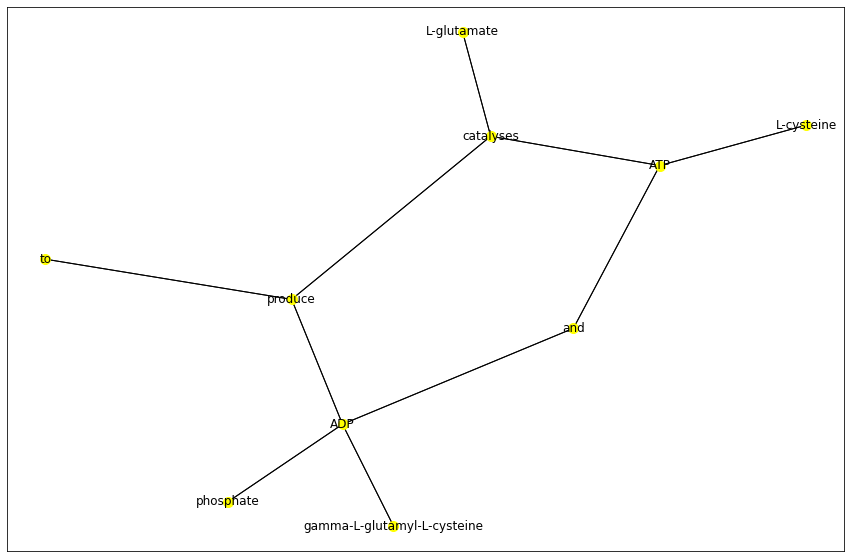

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos,arrows=False,node_size=100,node_color='yellow',font_size=12)
plt.show()

## Add new links aroud "VERB" to construct clique

In [155]:
G.add_edge('catalyses','L-cysteine',weight=3)
G.add_edge('L-cysteine','catalyses',weight=3)
G.add_edge('produce','phosphate',weight=3)
G.add_edge('produce','gamma-L-glutamyl-L-cysteine',weight=3)
G.add_edge('phosphate','gamma-L-glutamyl-L-cysteine',weight=3)

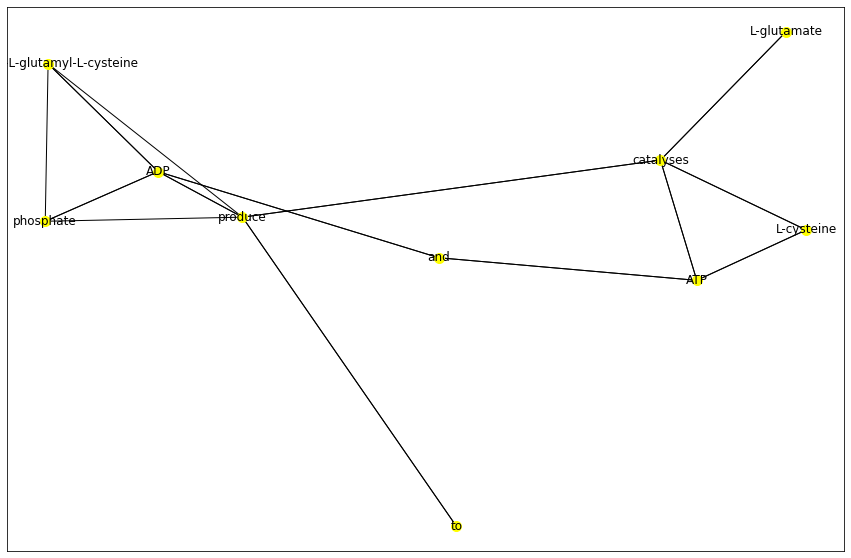

In [156]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos,arrows=False,node_size=100,node_color='yellow',font_size=12)
plt.show()

In [157]:
nx.write_gpickle(G, "sample_enzyme_new.gpickle")

## Generate Random Walk from Sentence Graph 

In [158]:
G = nx.read_gpickle("sample_enzyme_new.gpickle")

In [159]:
l = [n for n in G.neighbors('catalyses')]

In [160]:
type(len(l))

int

In [161]:
print (l)

['ATP', 'produce', 'L-glutamate', 'L-cysteine']


In [162]:
node_weights = nx.get_node_attributes(G, "weight")

In [163]:
print (node_weights)

{'L-glutamate': 3, 'catalyses': 3, 'ATP': 3, 'and': 1, 'L-cysteine': 3, 'to': 1, 'produce': 3, 'ADP': 3, 'phosphate': 3, 'gamma-L-glutamyl-L-cysteine': 3}


In [164]:
edge_weights = nx.get_edge_attributes(G, 'weight')

In [165]:
print (edge_weights)

{('L-glutamate', 'catalyses'): 3, ('catalyses', 'ATP'): 3, ('catalyses', 'produce'): 1, ('catalyses', 'L-glutamate'): 3, ('catalyses', 'L-cysteine'): 3, ('ATP', 'L-cysteine'): 3, ('ATP', 'catalyses'): 3, ('ATP', 'and'): 1, ('and', 'ATP'): 1, ('and', 'ADP'): 1, ('L-cysteine', 'ATP'): 3, ('L-cysteine', 'catalyses'): 3, ('to', 'produce'): 1, ('produce', 'ADP'): 3, ('produce', 'catalyses'): 1, ('produce', 'to'): 1, ('produce', 'phosphate'): 3, ('produce', 'gamma-L-glutamyl-L-cysteine'): 3, ('ADP', 'produce'): 3, ('ADP', 'phosphate'): 3, ('ADP', 'gamma-L-glutamyl-L-cysteine'): 3, ('ADP', 'and'): 1, ('phosphate', 'ADP'): 3, ('phosphate', 'gamma-L-glutamyl-L-cysteine'): 3, ('gamma-L-glutamyl-L-cysteine', 'ADP'): 3}


In [166]:
edge_weights[('ATP', 'L-cysteine')]

3

In [167]:
('ATP','L-cysteine') in edge_weights.keys()

True

In [168]:
('L-cysteine','ATP') in edge_weights.keys()

True

In [169]:
# Testing one of the setups
import numpy as np
a = np.array([1,2,3])
b = np.array([1,2,3])
print (np.multiply(a,b))

[1 4 9]


In [170]:
# Helper functions
import numpy as np
def retrieve_edge_wgt(v1, v2, weight):
    """ to handle the directionality of node pair """
    if (v1, v2) in weight.keys():
        return weight[(v1, v2)]
    else:
        return weight[(v2, v1)]

def get_Weighted_Neighbours(G, node):
    """ 
    Generate a list of neighbours of 
    a node with corresponding probability 
    """
    node_weights = nx.get_node_attributes(G, "weight")
    
    
    # Prepare neighbour list and obtain weight of each attribute for nodes and edges
    edge_wgts = nx.get_edge_attributes(G, "weight")
    node_neighbours = [adj_node for adj_node, datadict in G[node].items()]
    self_node_wgt = np.array(len(node_neighbours))*node_weights[node]
    # print (self_node_wgt)
    neighbour_wgts = [datadict['weight'] for adj_node, datadict in G[node].items()]
    neighbour_pair_wgts = list()
    for neigbhour in node_neighbours:
        neighbour_pair_wgts.append(edge_wgts[(node, neigbhour)])
    
    # Calculate the transition probability from start node to respective neighbour
    elementwise_wgts = np.multiply(self_node_wgt, np.array(neighbour_wgts), np.array(neighbour_pair_wgts))
    total_weight = sum(elementwise_wgts)
    neighbour_prob = [weight/total_weight for weight in elementwise_wgts]
    
    return node_neighbours, neighbour_prob

In [171]:
neighbour_list, neighbour_prob = get_Weighted_Neighbours(G, 'L-glutamate')

In [172]:
print (neighbour_list)
print (neighbour_prob)

['catalyses']
[1.0]


In [173]:
# Obtain next node
import random

def get_nextNode(G, start_node):
    """ 
    obtain next node of a given start_node
    """
    neighbour_list, neighbour_prob = get_Weighted_Neighbours(G, start_node)
    next_node = random.choices(neighbour_list, neighbour_prob)
    return next_node

In [174]:
next_node = get_nextNode(G, 'catalyses')

In [175]:
print (next_node)

['ATP']


In [176]:
def get_random_walk(graph, start_node, n_steps:10):
    """ 
    Given a graph and a node, 
    return a random walk starting from the node 
    """
    local_path = [start_node]
    node = start_node
    for i in range(n_steps):
        next_node = get_nextNode(G, node)
        local_path.append(next_node[0])
        node = next_node[0]
    return local_path

In [177]:
# Testing
path = get_random_walk(graph=G, start_node='L-glutamate', n_steps=10)

In [178]:
print (path)

['L-glutamate', 'catalyses', 'ATP', 'catalyses', 'ATP', 'L-cysteine', 'catalyses', 'L-cysteine', 'ATP', 'and', 'ADP']


In [179]:
# Construct a list collecting these random walks
nodes = [G.nodes]
print (nodes)

[NodeView(('L-glutamate', 'catalyses', 'ATP', 'and', 'L-cysteine', 'to', 'produce', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine'))]


In [180]:
path_collection = list()
for node in tqdm(G.nodes):
    for i in range(1000):
        path = get_random_walk(graph=G, start_node=node, n_steps=200)
        path_collection.append(path)

100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


In [181]:
print (path_collection[0])

['L-glutamate', 'catalyses', 'L-cysteine', 'ATP', 'catalyses', 'ATP', 'catalyses', 'ATP', 'L-cysteine', 'catalyses', 'produce', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'phosphate', 'ADP', 'produce', 'to', 'produce', 'phosphate', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'phosphate', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'phosphate', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'phosphate', 'ADP', 'produce', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'phosphate', 'ADP', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'ADP', 'produce', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'produce', 'ADP', 'produce', 'gamma-L-glutamyl-L-cysteine', 'ADP', 'phosphate', 'gamma-L-

In [182]:
len(path_collection)

10000

In [183]:
df = pd.DataFrame(index=range(len(path_collection)), columns=['path'])

In [184]:
for i in range(len(path_collection)):
    df.loc[i, 'path'] = path_collection[i]

In [185]:
df.head()

,path
0,"[L-glutamate, catalyses, L-cysteine, ATP, cata..."
1,"[L-glutamate, catalyses, L-glutamate, catalyse..."
2,"[L-glutamate, catalyses, L-glutamate, catalyse..."
3,"[L-glutamate, catalyses, ATP, catalyses, produ..."
4,"[L-glutamate, catalyses, L-glutamate, catalyse..."


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [187]:
df.to_csv(PATH+"RandomWalk_new.csv",index=False)